## Insect Egg Count

Guillaume gave a good solution [here](https://forum.image.sc/t/insect-egg-counts-help-any-ideas-on-how-i-can-segment-and-accurately-count-eggs/90643/3)

I re-use his code, convert the max locations to labels then fix a few mistakes.  Next step I will try some deep learning (which is perhaps overkill for this question)

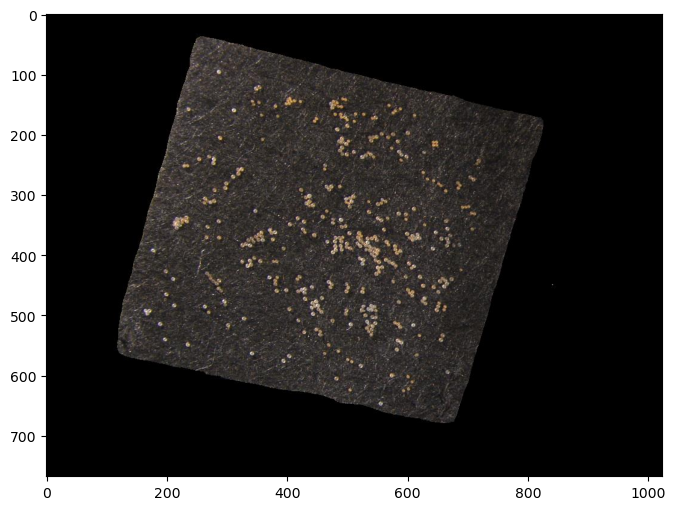

In [54]:
from skimage.io import imread
import skimage
from tnia.plotting.plt_helper import imshow2d
import napari
from scipy import ndimage as ndi
import os
import numpy as np

tnia_images_path = r"D:\images\tnia-python-images"

im_rgb = imread(os.path.join(tnia_images_path, r"imagesc\2024_01_10_insect_egg_count\I1_F1_O20_SWI_R1_13-09-23.tif"))
            
fig = imshow2d(im_rgb)

In [56]:
# convert to gray and create a smoothed version
im = skimage.color.rgb2gray(im_rgb)
im_gauss = skimage.filters.gaussian(im, sigma=1)

# create a simple binary mask to avoid detecting eggs in background
mask = (im_gauss > 0.4)

# isolate one egg as template 
template = im[333:341,456:464]

# compare image and template
result = skimage.feature.match_template(im, template, pad_input=True)
result_masked = result * mask


# get local maxima
coords = skimage.feature.peak_local_max(result_masked, threshold_abs=0.1, min_distance=2)
    
max_locations = np.zeros(im.shape, dtype=bool)
max_locations[tuple(coords.T)] = True
markers, _ = ndi.label(max_locations)

# visualize
viewer = napari.Viewer()
viewer.add_image(im, name='im')
viewer.add_image(im_gauss, name='im_gauss')
viewer.add_image(result, name='template match result')
viewer.add_image(max_locations)
viewer.add_points(coords, face_color=[0,0,0,0], edge_color='red')

<Points layer 'coords' at 0x1fed12367f0>

In [31]:
help(skimage.feature.peak_local_max)

Help on function peak_local_max in module skimage.feature.peak:

peak_local_max(image, min_distance=1, threshold_abs=None, threshold_rel=None, exclude_border=True, num_peaks=inf, footprint=None, labels=None, num_peaks_per_label=inf, p_norm=inf)
    Find peaks in an image as coordinate list.
    
    Peaks are the local maxima in a region of `2 * min_distance + 1`
    (i.e. peaks are separated by at least `min_distance`).
    
    If both `threshold_abs` and `threshold_rel` are provided, the maximum
    of the two is chosen as the minimum intensity threshold of peaks.
    
    .. versionchanged:: 0.18
        Prior to version 0.18, peaks of the same height within a radius of
        `min_distance` were all returned, but this could cause unexpected
        behaviour. From 0.18 onwards, an arbitrary peak within the region is
        returned. See issue gh-2592.
    
    Parameters
    ----------
    image : ndarray
        Input image.
    min_distance : int, optional
        The minimal 

## convert max locations to circular labels

We create quick and dirty labels by drawing a circle of apr. radius = 3.5 at each max location.

Kind of klugy gut the circle is given a random component so that each pixelated circle is a little different.  Certainly there is a better way to draw the circles. 

In [45]:
from tnia.simulation.phantoms import add_small_to_large_2d
from raster_geometry import circle
labels = np.zeros(im.shape, dtype=int)
l = 0

circle_ = circle([7,7],3)

for c in coords:
    l += 1
    r = 3+np.random.random()
    circle_ = circle([7,7],r)
    add_small_to_large_2d(labels, l*circle_, c[1], c[0], mode='replace')


## edit in napari

Now edit the labels in Napari.  When I did it, I just fixed some obvious mixes and tweaked some of the clusters a bit (the clusters are really hard so who knows if I imporved the situation there, I did fix some obvious misses though)

In [53]:
viewer=napari.Viewer()
viewer.add_image(im)
viewer.add_labels(labels)

<Labels layer 'labels' at 0x1feb57e0220>

In [52]:
## save labels
from skimage.io import imsave

imsave(os.path.join(tnia_images_path, r"imagesc\2024_01_10_insect_egg_count\I1_F1_O20_SWI_R1_13-09-23_labels.tif"), labels)

C:\Users\bnort\AppData\Local\Temp\ipykernel_21724\2581065637.py:4: UserWarning: D:\images\tnia-python-images\imagesc\2024_01_10_insect_egg_count\I1_F1_O20_SWI_R1_13-09-23_labels.tif is a low contrast image
  imsave(os.path.join(tnia_images_path, r"imagesc\2024_01_10_insect_egg_count\I1_F1_O20_SWI_R1_13-09-23_labels.tif"), labels)
